Computer lab with Jupyter notebooks where the participants can investigate the firing properties of Izhikevich models with different firing patterns and try to hand tune parameters to fit some specified recordings.

# Izhekevich Model

$$ dV_m/dt = 0.04 V_m^2 + 5 V_m + 140 - u + I $$
$$ du/dt = a (b V_m - u)$$
if $Vm≥Vth$: then $V_m \leftarrow c$, $u \leftarrow u + d$

| Variable               | Units   | Description                                     |
|------------------------|---------|-------------------------------------------------|
| V_m                    | mV      | Membrane potential                              |
| U_m                    | mV      | Membrane potential recovery variable            |
| V_th                   | mV      | Spike threshold                                 |
| I_e                    | nA      | Constant input current (R=1)                    |
| a                      | real    | Describes time scale of recovery variable       |
| b                      | real    | Sensitivity of recovery variable                |
| c                      | mV      | After-spike reset value of V_m                  |
| d                      | mV      | After-spike reset value of U_m                  |

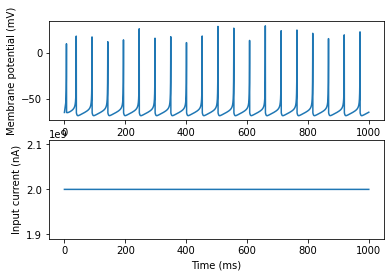

In [1]:
import brian2
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import brian2
from brian2 import NeuronGroup, Synapses, SpikeMonitor, StateMonitor
from brian2 import ms, mV, nA
from brian2 import defaultclock, run

brian2.start_scope()
# Define the Izhekevich model equations
eqs = """dv/dt = (0.04*v**2 + 5*v + 140 - u + I )/ms : 1
         du/dt = (a*(b*v - u))/ms  : 1
         I : 1
         a : 1
         b : 1
         c : 1
         d : 1
       """

# Create a neuron group with a single neuron using the model and parameters
neuron = NeuronGroup(1, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")

# Set the parameters for the model
neuron.a = 0.02
neuron.b = 0.25
neuron.c = -65
neuron.d = 2

# Define the initial conditions for the model
v0 = -70 * mV
u0 = neuron.b * v0/ms

# Set the initial values for the neuron's membrane potential and recovery variable
neuron.v = -65
neuron.u = "b*v"

# Set the input current for the neuron
input_current = 2 # nA
neuron.I = input_current

# Create a monitor to record the neuron's membrane potential and input current
monitors = StateMonitor(neuron, ['v', 'I'], record=True)

# Run the simulation for 100 milliseconds
dur = 1000 * ms
run(dur)

# Plot the neuron's membrane potential and input current over time
plt.figure()
plt.subplot(211)
plt.plot(monitors.t/ms, monitors.v[0])
plt.ylabel('Membrane potential (mV)')
plt.subplot(212)
plt.plot(monitors.t/ms, monitors.I[0]/nA)
plt.ylabel('Input current (nA)')
plt.xlabel('Time (ms)')
plt.show()


Create a network of spiking neurons
Adapted from https://brian2.readthedocs.io/en/stable/examples/frompapers.Izhikevich_2003.html based on http://izhikevich.org/publications/spikes.htm

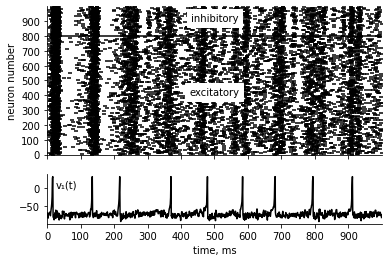

In [2]:
# import matplotlib.pyplot as plt
# import numpy as np
# import brian2
# from brian2 import NeuronGroup, Synapses, SpikeMonitor, StateMonitor
# from brian2 import ms, mV
# from brian2 import defaultclock, run
brian2.start_scope()
tfinal = 1000 * ms
Ne = 800
Ni = 200

re = np.random.uniform(size=Ne)
ri = np.random.uniform(size=Ni)
weights = np.hstack(
    [
        0.5 * np.random.uniform(size=(Ne + Ni, Ne)),
        -np.random.uniform(size=(Ne + Ni, Ni)),
    ]
).T

defaultclock.dt = 1 * ms

eqs = """dv/dt = (0.04*v**2 + 5*v + 140 - u + I + I_noise )/ms : 1
         du/dt = (a*(b*v - u))/ms  : 1
         I : 1
         I_noise : 1
         a : 1
         b : 1
         c : 1
         d : 1
       """

N = NeuronGroup(Ne + Ni, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")
N.v = -65

N_exc = N[:Ne]
N_inh = N[Ne:]

spikemon = SpikeMonitor(N)
statemon = StateMonitor(N, 'v', record=0, when='after_thresholds')
N_exc.a = 0.02
N_exc.b = 0.2
N_exc.c = -65 + 15 * re**2
N_exc.d = 8 - 6 * re**2

N_inh.a = 0.02 + 0.08 * ri
N_inh.b = 0.25 - 0.05 * ri
N_inh.c = -65
N_inh.d = 2

N_exc.u = "b*v"
N_inh.u = "b*v"

S = Synapses(
    N,
    N,
    "w : 1",
    on_pre={"up": "I += w", "down": "I -= w"},
    delay={"up": 0 * ms, "down": 1 * ms},
)
S.connect()
S.w[:] = weights.flatten()


# Run abstract code in the group’s namespace.
# The created CodeRunner object will be automatically added to the group, it therefore does not need to be added to the network manually. However, a reference to the object will be returned, which can be used to later remove it from the group or to set it to inactive.
N_exc.run_regularly("I_noise = 5*randn()", dt=1 * ms)
N_inh.run_regularly("I_noise = 2*randn()", dt=1 * ms)

run(tfinal)

fig, (ax, ax_voltage) = plt.subplots(2, 1, sharex=True,
                                     gridspec_kw={'height_ratios': (3, 1)})

ax.scatter(spikemon.t / ms, spikemon.i[:], marker="_", color="k", s=10)
ax.set_xlim(0, tfinal / ms)
ax.set_ylim(0, len(N))
ax.set_ylabel("neuron number")
ax.set_yticks(np.arange(0, len(N), 100))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(Ne, color="k")
ax.text(500, 900, 'inhibitory', backgroundcolor='w', color='k', ha='center')
ax.text(500, 400, 'excitatory', backgroundcolor='w', color='k', ha='center')

ax_voltage.plot(statemon.t / ms, np.clip(statemon.v[0], -np.inf, 30),
               color='k')
ax_voltage.text(25, 0, 'v₁(t)')
ax_voltage.set_xticks(np.arange(0, tfinal / ms, 100))
ax_voltage.spines['right'].set_visible(False)
ax_voltage.spines['top'].set_visible(False)
ax_voltage.set_xlabel("time, ms")

plt.show()

Qualitative features of neuron firing (bursting, spike frequency adaptation, rebound spiking)

Extract electrophysiological features using Blue Brain Project Electrophys Feature Extraction Library eFEL (https://efel.readthedocs.io/en/latest/index.html)

Description of all features at: https://efel.readthedocs.io/en/latest/eFeatures.html


In [60]:
import efel
efel_feat = efel.getFeatureNames()

efel_feat = ['AP_amplitude','AP_duration','AP_height', 'AP_width', 'ISI_CV', 'ISI_values', 'Spikecount', 'Spikecount_stimint',
 'adaptation_index', 'adaptation_index2', 'irregularity_index', 'mean_frequency',  'spike_half_width','spike_width2']

# A 'trace' is a dictionary for input into efel feature extraction
trace1 = {}
trace1['T'] = monitors.t/ms # Set the 'T' (=time) key of the trace
trace1['V'] = monitors.v[0] # Set the 'V' (=voltage) key of the trace
trace1['stim_start'] = [monitors.t[0]/ms] # Set the 'stim_start' (time at which a stimulus starts, in ms) # must be a list (with one element)
trace1['stim_end'] = [monitors.t[-1]/ms] # Set the 'stim_end' (time at which a stimulus end) key of the trace # must be a list (with one element)

# Multiple traces can be passed to the eFEL at the same time, so the argument should be a list
traces = [trace1]

# feature extraction settings
efel.api.setThreshold(-30)  # set spike detection threshold
efel.setDoubleSetting('interp_step', np.unique(np.around(np.gradient(monitors.t/ms), decimals=5))[0])  # set interpolation step to sampling rate or simulation step size

# extract features
traces_results = efel.getFeatureValues(traces, efel_feat, raise_warnings=False)

# print results of efel feature extraction
for c in traces_results:
    for key in c:
        print(key)
        print(c[key], "\n")

AP_amplitude
[56.76790514 63.86179327 63.00944797 58.12932643 59.97466691 72.53490659
 61.7089464  63.26677577 57.19728724 63.97681391 74.99963608 73.17573986
 59.41366119 75.59676655 70.48617528 71.25667219 67.8315128  61.28268369
 65.12289178 69.29836986] 

AP_duration
[1.5 1.5 1.5 1.5 1.5 1.6 1.5 1.5 1.5 1.5 1.6 1.6 1.5 1.6 1.6 1.6 1.6 1.5
 1.5 1.6] 

AP_height
[ 9.93346076 18.29556299 17.39080751 12.2118742  14.17348134 26.28617079
 16.01334681 17.66314581 11.21949567 18.41423839 28.85829646 26.95534519
 13.57756733 29.48080635 24.14477335 24.9504954  21.36512247 15.56145179
 19.62548139 22.90175122] 

AP_width
[0.5 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6] 

ISI_CV
[0.00237773] 

ISI_values
[51.8 51.7 51.6 51.7 51.9 51.7 51.7 51.6 51.8 52.  51.9 51.7 52.  51.9
 51.9 51.8 51.7 51.8] 

Spikecount
[20] 

Spikecount_stimint
[20] 

adaptation_index
[6.03859126e-05] 

adaptation_index2
[-5.27795548e-10] 

irregularity_index
[0.12222222] 

mean_frequen

Demonstrate how to access data from Allen Brain Institute

3Hand fitting of model to example data from Allen Brain Institute?